In [1]:
%matplotlib inline
# %matplotlib

In [2]:
from __future__ import division,print_function

In [3]:
from spartan.utils.sklearn import model_assessment, feature_selection
from spartan.utils.sklearn import pandas_helpers

In [4]:
from collections import Counter, defaultdict
import math

import numpy as np
import pandas as pd
import sklearn as skl
import sklearn.preprocessing as ppro

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA, RandomizedPCA, KernelPCA, FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.linear_model import Lasso

from sklearn.feature_selection import SelectKBest

from sklearn.metrics import confusion_matrix

from sklearn.feature_selection import SelectFromModel

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
sns.set_context('poster')

In [7]:
tax_path = "/home/gus/MEGAsync/zim/main/BCH/Projects/Amy/2016-01-07_~_16s_data/otu_table_mc2_w_tax_no_pynast_failures.biom.TAXON.tsv"
map_path = "/home/gus/MEGAsync/zim/main/BCH/Projects/Amy/2016-01-07_~_16s_data/BL6SPFDec16map.txt"

In [8]:
tax = pd.read_csv(filepath_or_buffer=tax_path, sep='\t', 
                  quoting=0, skipinitialspace=False, lineterminator=None, header='infer', index_col=None, names=None)

meta = pd.read_csv(filepath_or_buffer=map_path, sep='\t')

In [9]:
tax.head()

,OTU ID,23,25,27,28,30,39,41,8,24,7,9,5
0,206494,33,16,190,11,92,12,2272,2,0,0,0,0
1,276629,0,0,1,0,0,0,0,0,1,1,0,0
2,276620,0,0,0,0,0,0,0,0,2,1,1,0
3,330294,0,0,0,0,0,0,2,0,0,0,2,0
4,184456,1,0,0,0,0,0,1,0,0,0,0,0


In [10]:
tax.index = tax['OTU ID'].values
tax = tax.drop(['OTU ID'],axis=1)

In [11]:
tax.head()

,23,25,27,28,30,39,41,8,24,7,9,5
206494,33,16,190,11,92,12,2272,2,0,0,0,0
276629,0,0,1,0,0,0,0,0,1,1,0,0
276620,0,0,0,0,0,0,0,0,2,1,1,0
330294,0,0,0,0,0,0,2,0,0,0,2,0
184456,1,0,0,0,0,0,1,0,0,0,0,0


In [12]:
# tax_scaled = tax.T.apply(lambda m: (m - m.mean())/m.std()).T
# tax_scaled = tax.T.apply(lambda m: (m / m.sum())).T
# tax_scaled = tax

tax_shrunk = tax.sum().min() / tax.sum() * tax

# tax_scaled = tax_shrunk.T.apply(lambda m: (m - m.mean())/m.std()).T

tax_scaled = tax_shrunk

In [13]:
tax_scaled.head()

,23,25,27,28,30,39,41,8,24,7,9,5
206494,11.695910,8.111475,64.234237,3.754549,30.92053,6.314528,952.449320,2,0.000000,0.000000,0.000000,0
276629,0.000000,0.000000,0.338075,0.000000,0.00000,0.000000,0.000000,0,0.492467,0.222158,0.000000,0
276620,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0,0.984934,0.222158,0.432660,0
330294,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.838424,0,0.000000,0.000000,0.865319,0
184456,0.354422,0.000000,0.000000,0.000000,0.00000,0.000000,0.419212,0,0.000000,0.000000,0.000000,0


In [14]:
meta.SampleID = meta.SampleID.astype(str)

# Join meta data

In [15]:
# meta.set_index('SampleID')

In [16]:
meta['WT or not'] = meta.Genotype1.apply(lambda i: i if i == 'WT' else 'mutant')
meta.head()

,SampleID,Mouse ID,Gender,DOB,Ear Tag,Genotype1,Genotype,Cage,Notes,WT or not
0,23,I175,F,7/6/15,R,WT,WT (08/25/15) cre+ (08/26/15),943947,Parent cage 892230,WT
1,24,I176,F,7/5/15,L,WT,WT,943947,Parent cage 892234,WT
2,25,I177,F,7/4/15,-,TregWKO,WASp fl/fl (08/25/15) cre+ (09/08/15),943947,Parent cage 892221,mutant
3,41,I208,F,7/1/15,RL,WT,WT,943947,Parent cage 892226,WT
4,27,I179,F,7/7/15,2L,WKO,WKO (8/20/15),943947,Parent cage 892227,mutant


In [17]:
full_table = meta.set_index('SampleID').join(tax_scaled.T).reset_index()

In [18]:
full_table.head()

,SampleID,Mouse ID,Gender,DOB,Ear Tag,Genotype1,Genotype,Cage,Notes,WT or not,...,New.CleanUp.ReferenceOTU56003,New.CleanUp.ReferenceOTU56005,New.CleanUp.ReferenceOTU56008,New.CleanUp.ReferenceOTU56017,New.CleanUp.ReferenceOTU56020,New.CleanUp.ReferenceOTU56032,New.CleanUp.ReferenceOTU56042,New.CleanUp.ReferenceOTU56061,New.CleanUp.ReferenceOTU56065,New.CleanUp.ReferenceOTU56069
0,23,I175,F,7/6/15,R,WT,WT (08/25/15) cre+ (08/26/15),943947,Parent cage 892230,WT,...,0.354422,0.000000,0.354422,0.354422,0.000000,0,0.000000,0.000000,0.000000,0
1,24,I176,F,7/5/15,L,WT,WT,943947,Parent cage 892234,WT,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
2,25,I177,F,7/4/15,-,TregWKO,WASp fl/fl (08/25/15) cre+ (09/08/15),943947,Parent cage 892221,mutant,...,0.000000,0.506967,0.000000,0.000000,0.506967,0,0.000000,0.506967,0.000000,0
3,41,I208,F,7/1/15,RL,WT,WT,943947,Parent cage 892226,WT,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
4,27,I179,F,7/7/15,2L,WKO,WKO (8/20/15),943947,Parent cage 892227,mutant,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.338075,0.338075,0.338075,0


# Encode 'y' (labels)

In [19]:
y_geno_any_mut = full_table['WT or not']
y_geno_spc_mut = full_table['Genotype1']
geno_encoder = ppro.LabelEncoder()
y_geno_encoded_any = geno_encoder.fit_transform(y_geno_any_mut)
y_geno_encoded_spc = geno_encoder.fit_transform(y_geno_spc_mut)

# Encode 'X' (data)

## Combine (or not) the categorical and numerical data types for X

In [20]:
X_cols_cat = list(full_table.columns[[2,7]].values)
X_cols_num = list(full_table.columns[10:])

In [21]:
# X_cols_num

In [22]:
# make the dummy variable columns for the original categorical data columns
# HOPEFULLY we dont run into colinearity issues
X_data_cat = pd.get_dummies(full_table[X_cols_cat].astype(str))

In [23]:
X_data_cat

,Gender_F,Gender_M,Cage_943947,Cage_943948,Cage_943951
0,1,0,1,0,0
1,1,0,1,0,0
2,1,0,1,0,0
3,1,0,1,0,0
4,1,0,1,0,0
5,0,1,0,1,0
6,0,1,0,1,0
7,0,1,0,1,0
8,0,1,0,1,0
9,1,0,0,0,1


In [24]:
# To avoid colinearity we remove one column from each class of categorical 
X_data_cat = X_data_cat[['Gender_F', 'Cage_943947', 'Cage_943948']]
X_data_cat

,Gender_F,Cage_943947,Cage_943948
0,1,1,0
1,1,1,0
2,1,1,0
3,1,1,0
4,1,1,0
5,0,0,1
6,0,0,1
7,0,0,1
8,0,0,1
9,1,0,0


In [25]:
# put all data columns together
X = pd.concat([X_data_cat,full_table[X_cols_num]],axis=1) # Accounting for Cages and Sex
# X = full_table[X_cols_num] # IGNORING Cages and Sex

In [26]:
X.head()

,Gender_F,Cage_943947,Cage_943948,206494,276629,276620,330294,184456,273164,182583,...,New.CleanUp.ReferenceOTU56003,New.CleanUp.ReferenceOTU56005,New.CleanUp.ReferenceOTU56008,New.CleanUp.ReferenceOTU56017,New.CleanUp.ReferenceOTU56020,New.CleanUp.ReferenceOTU56032,New.CleanUp.ReferenceOTU56042,New.CleanUp.ReferenceOTU56061,New.CleanUp.ReferenceOTU56065,New.CleanUp.ReferenceOTU56069
0,1,1,0,11.695910,0.000000,0.000000,0.000000,0.354422,0.354422,0,...,0.354422,0.000000,0.354422,0.354422,0.000000,0,0.000000,0.000000,0.000000,0
1,1,1,0,0.000000,0.492467,0.984934,0.000000,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
2,1,1,0,8.111475,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0.000000,0.506967,0.000000,0.000000,0.506967,0,0.000000,0.506967,0.000000,0
3,1,1,0,952.449320,0.000000,0.000000,0.838424,0.419212,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
4,1,1,0,64.234237,0.338075,0.000000,0.000000,0.000000,0.676150,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.338075,0.338075,0.338075,0


In [27]:
X.iloc[:,3:].head()

,206494,276629,276620,330294,184456,273164,182583,4359056,339886,193680,...,New.CleanUp.ReferenceOTU56003,New.CleanUp.ReferenceOTU56005,New.CleanUp.ReferenceOTU56008,New.CleanUp.ReferenceOTU56017,New.CleanUp.ReferenceOTU56020,New.CleanUp.ReferenceOTU56032,New.CleanUp.ReferenceOTU56042,New.CleanUp.ReferenceOTU56061,New.CleanUp.ReferenceOTU56065,New.CleanUp.ReferenceOTU56069
0,11.695910,0.000000,0.000000,0.000000,0.354422,0.354422,0,0.000000,0.354422,0,...,0.354422,0.000000,0.354422,0.354422,0.000000,0,0.000000,0.000000,0.000000,0
1,0.000000,0.492467,0.984934,0.000000,0.000000,0.000000,0,0.000000,0.492467,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
2,8.111475,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.506967,2.027869,0,...,0.000000,0.506967,0.000000,0.000000,0.506967,0,0.000000,0.506967,0.000000,0
3,952.449320,0.000000,0.000000,0.838424,0.419212,0.000000,0,0.000000,0.419212,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
4,64.234237,0.338075,0.000000,0.000000,0.000000,0.676150,0,0.338075,0.676150,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.338075,0.338075,0.338075,0


In [28]:


pca = PCA(n_components=2, whiten=False)
# pca = RandomizedPCA(n_components=2, whiten=False)


pca_t = pca.fit_transform(X.iloc[:,3:],y_geno_encoded_spc)
top_n_comp = 2
# print('explained_variance_ratio_ of top {num}: {val}'.format(num=top_n_comp,val=pca.explained_variance_ratio_[:top_n_comp].sum()))

pca_t_l = pandas_helpers.repandasify(array=pca_t, y_names=geno_encoder.inverse_transform(y_geno_encoded_spc), X_names=['PC {v_}'.format(v_=v+1) for v in range(len(pca_t[0]))])
print(pca_t_l)

                PC 1         PC 2
WT      -2441.361773   617.178793
WT       -762.646881  -787.231665
TregWKO -1221.904399   862.216459
WT        438.402942  -133.668706
WKO       -39.377096  -439.806611
WKO      2108.222826  -654.972110
TregWKO  1959.694971  2290.978857
WT        567.495647 -1031.268589
WT        781.772676  -314.729878
WKO      -245.316581 -1422.199948
TregWKO  -868.157524   582.795104
TregWKO  -276.824807   430.708294


In [29]:
pca_t_l = pandas_helpers.repandasify(array=pca_t, y_names=geno_encoder.inverse_transform(y_geno_encoded_spc), X_names=['PC {v_}'.format(v_=v+1) for v in range(len(pca_t[0]))])

pca_t_l['geno'] = pca_t_l.index.values
pca_t_l = pca_t_l.reset_index(drop=True)
pca_t_l['Cage'] = full_table.Cage.astype(str)
pca_t_l['Sex'] = full_table.Gender
pca_t_l['Specific Genotype'] = full_table.Genotype1
# pca_t_l

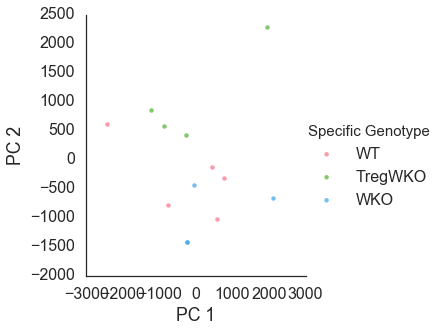

In [30]:
with sns.color_palette(sns.color_palette("hls", 2)):
    with sns.axes_style("white"):
        sns.lmplot(x='PC 1', y='PC 2', data=pca_t_l.append(pca_t_l.iloc[9,:]), #sns.lmplot(x='PC 1', y='PC 2', data=pca_t_l,
                   hue='Specific Genotype', palette=None,
                   fit_reg=False,
                   scatter_kws={'alpha':0.7}
                  );